# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

# План работы

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                   FunctionTransformer,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (StratifiedKFold,
                                     cross_validate,
                                     GridSearchCV)
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             average_precision_score)
import joblib

# Убираем ограничение на ширину колонок при выводе датафрейма
pd.set_option("display.max_colwidth", None)

# Фиксируем random_state
r_s = 42

# Загружаем данные
df = pd.read_csv('https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv',
                 delimiter=',',
                 decimal='.')
df_shape = df.shape

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

### 2.1. Данные и пользователи

Выведем информацию о датафрейме и первые несколько строк:

In [2]:
print(df.info())
display(df.iloc[:5,:15])
display(df.iloc[:5,15:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,light,almond,NaN,vietnam,large
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,light,whole,1.0,guatemala,medium
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,medium,oat,1.0,guatemala,small
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,medium,skim,0.0,brazil,medium
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,dark,almond,1.0,colombia,medium


,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,pro,30.468321,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,none,NaN,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,premium,17.895637,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,none,11.405533,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,none,15.948239,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1


Всего в датафрейме с данными о поведении пользователей компания Happy Beans Coffee 27 полей: 26 признаков и 1 целевая переменная. Типы данных во всех столбцах определены верно. Количество сток: 10450, что должно соответствовать количеству уникальных пользователей.  
Из описания задачи известно, что данные представлены в виде готовой анлитической витрины. Период агрегации: 4 последние недели (≈месяц). Также из описания известно, что каждый месяц сервис теряет 10% клиентской базы.  
На основе предоставленных данных необходимо обучить модель, предсказывающую уход клиента клиента.

На всякий случай убедимся, что все значения в поле `user_id` уникальны, и что в датафрейме нет дубликатов строк:

In [3]:
print(f"Количество уникальных пользователей: {df['user_id'].nunique()}")
print(f"Количество полных дубликатов строк: {df.duplicated().sum()}")

Количество уникальных пользователей: 10450
Количество полных дубликатов строк: 0


- Количество уникальных пользователей соответствует количеству строк датафрейма.
- Дубликатов не найдено.
- Количество пропусков в каждом из полей не превышает 10%. Подробнее пропуски разберем при выборе стратегии их обработки ниже.

### 2.2. Целевая переменная

Значения целевой переменной находятся в поле `churn` :
- `1` - пользовтель __перестал__ пользоваться сервисом;
- `0` - пользователь __породолжает__ пользоваться сервисом.

Проверим распределение значений:

In [4]:
churn_cnt = df['churn'].value_counts()
churn_cnt.name = 'count'

churn_perc = df['churn'].value_counts(normalize=True).round(4) * 100
churn_perc.name = 'percent'

pd.concat([churn_cnt,churn_perc], axis=1)

,count,percent
churn,,
0,9821,93.98
1,629,6.02


Наблюдается сильный дисбаланс классов в целевой переменной: __положительный класс составлет лишь 6% от всех наблюдений.__

### 2.3. Признаки

С описанием признаков, содержащихся в датасете, можно ознакомиться по [ссылке](https://code.s3.yandex.net/data-scientist/coffee_churn_description.pdf).

Проверим распределение данных в каждом поле, кроме `user_id` (поле с уникальными идентификаторами пользователей бесполезно для обучения модели). Начнем с числовых __бинарных признаков__:

In [5]:
# Список имен полей с бинарными данными
bi_feat_list = ['seasonal_menu_tried',
                'notifications_enabled',
                'coffee_preference_change']

# Список имен полей с числовыми данными
num_feat_list = [col for col in df.columns if (df[col].dtype == 'float64') &\
                 (col not in bi_feat_list)]

# Список имен полей с категориальными данными
cat_feat_list = [col for col in df.columns if (df[col].dtype == 'object')&\
                 (col != 'user_id')]

# Выводим информацию о распределении данных в столбцах с бинарными данными
for col in bi_feat_list:

    # количество строк, принадлежащей каждой из категорий столбца
    total_cnt = df[col].value_counts(dropna=False).sort_index()
    total_cnt.name = 'total_count'

    # процент строк, принадлежащей каждой из категорий столбца
    total_perc = df[col].value_counts(normalize=True,
                                      dropna=False).round(4) * 100
    total_perc.name = 'total_percent'

    # количество и процент строк каждой из категорий столбца,
    # в которых целевая переменная положительна
    positive_target = df.groupby(col, dropna=False).agg(
        positive_target_count = ('churn', 'sum'),
        positive_target_percent = ('churn', 'mean')
    )

    # объединяем данные
    bi_df = pd.concat([total_cnt,
                       total_perc,
                       positive_target], axis=1)
    
    # переводим доли положительной целевой переменной в проценты
    bi_df['positive_target_percent'] =\
        bi_df['positive_target_percent'].round(4) * 100

    # выводим датафрейм
    print(f'Распределение значений в поле {col}')
    display(bi_df)
    print()

Распределение значений в поле seasonal_menu_tried


,total_count,total_percent,positive_target_count,positive_target_percent
seasonal_menu_tried,,,,
0.0,2827,27.05,181,6.40
1.0,6634,63.48,403,6.07
NaN,989,9.46,45,4.55



Распределение значений в поле notifications_enabled


,total_count,total_percent,positive_target_count,positive_target_percent
notifications_enabled,,,,
0.0,2448,23.43,151,6.17
1.0,7465,71.44,445,5.96
NaN,537,5.14,33,6.15



Распределение значений в поле coffee_preference_change


,total_count,total_percent,positive_target_count,positive_target_percent
coffee_preference_change,,,,
0.0,7946,76.04,475,5.98
1.0,1894,18.12,113,5.97
NaN,610,5.84,41,6.72


- __seasonal_menu_tried__:
    - Большая часть пользователей знакома с сезонным меню (63%).
    - Доля ушедших клиентов для обоих классов этого признака примерна равная. Однако, для тех пользователей, у которых отсутствует значение признака, доля уходов заметно ниже.
- __notifications_enabled__:
    - У большинства клиентов включены уведомления (71%).
    - Те, у кого уведомления не включены, уходят несколько чаще, как и те, у кого нет данных в этом поле.
- __coffee_preference_change__:
    - Изменение вкусовых предпочтений зафиксировано менее чем у пятой части пользователей.
    - Те клиенты, у которых есть данные в этом поле (вне зависимости от значения) уходят немного реже среднего (5.98% и 5.97% против среднего значения 6.02%). А те, у кого пропуск в этом поле, уходят существенно чаще.

__Далее проверим распределение числовых признаков:__

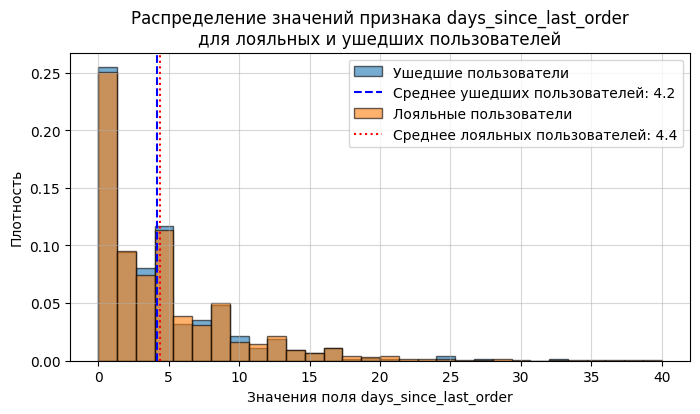

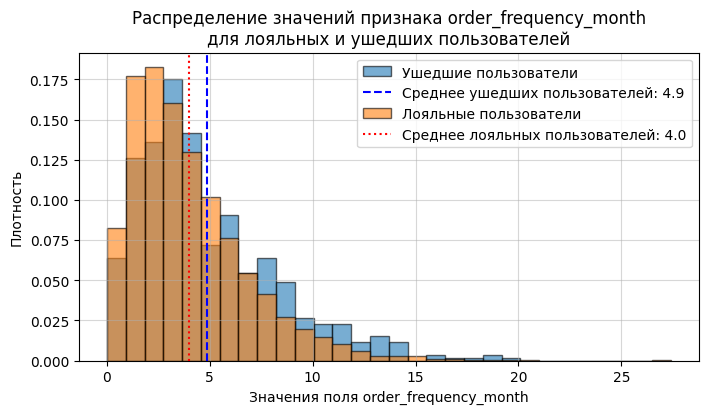

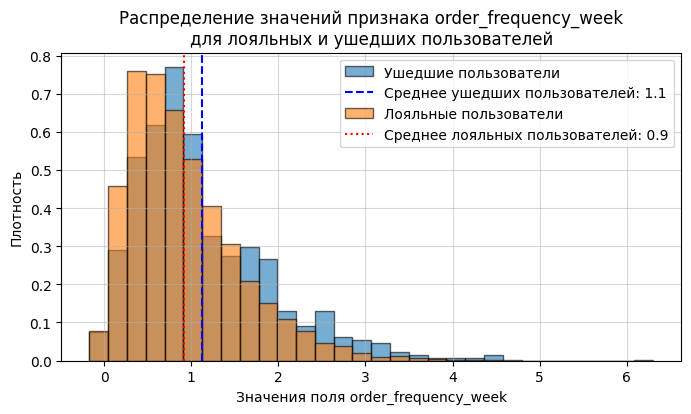

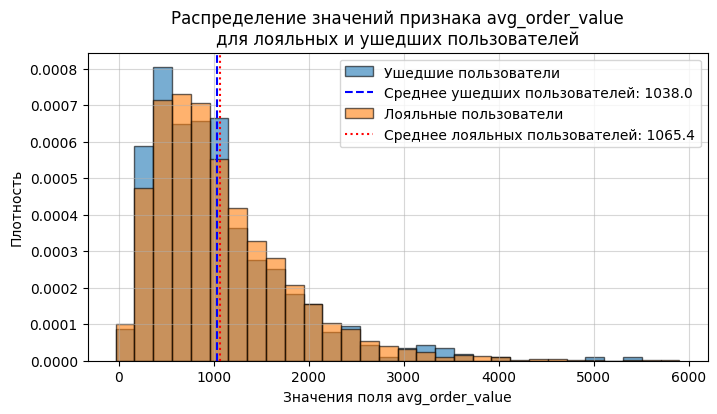

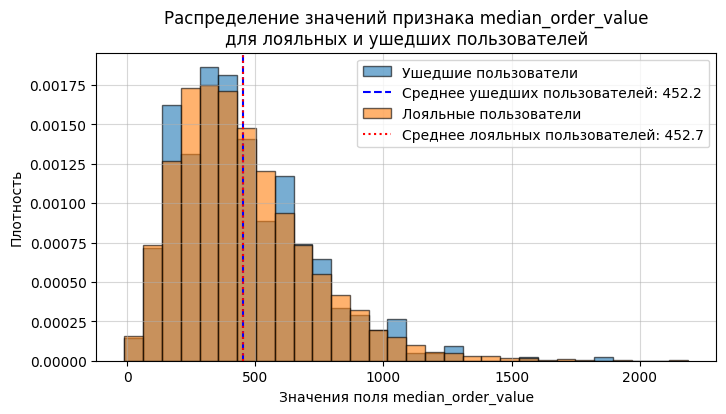

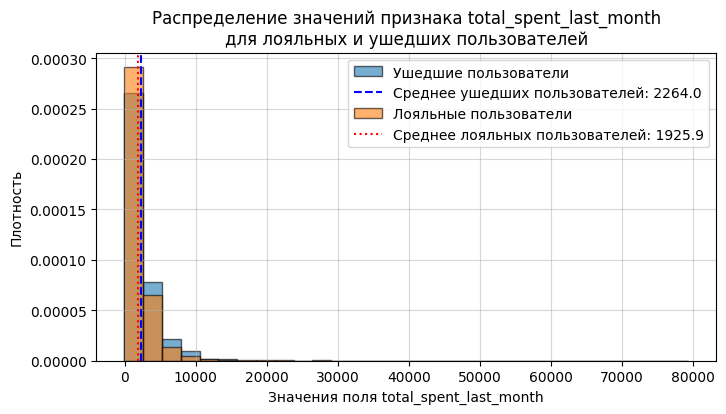

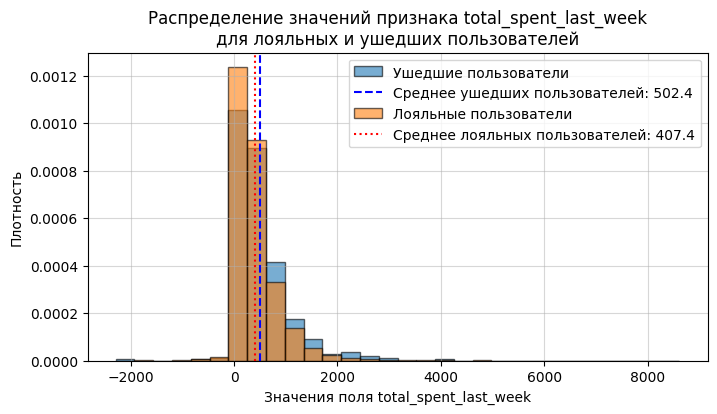

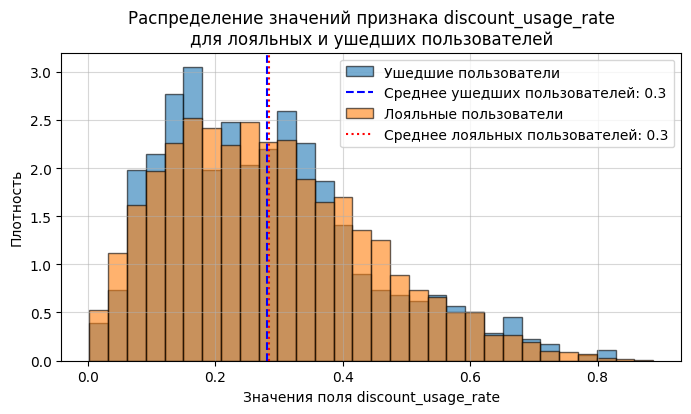

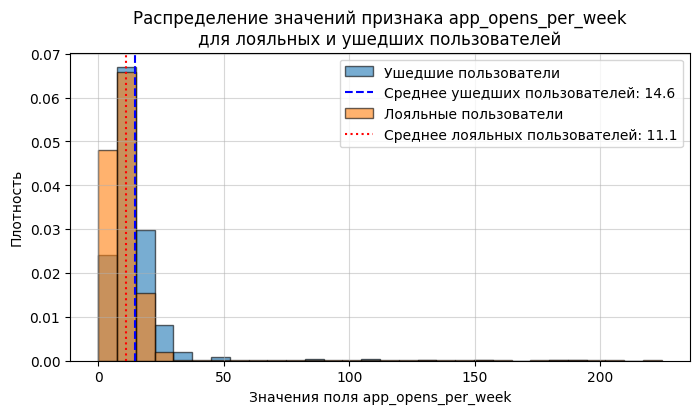

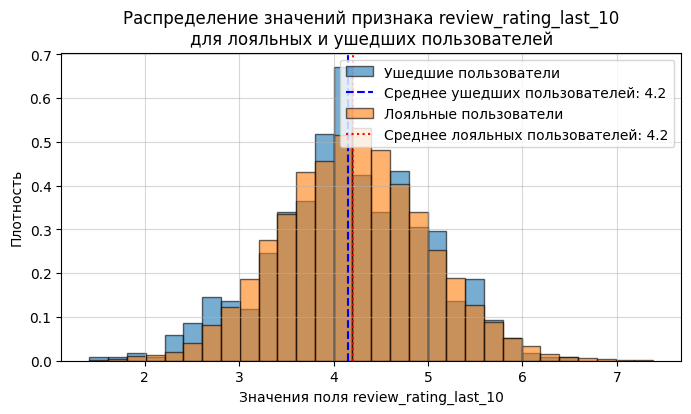

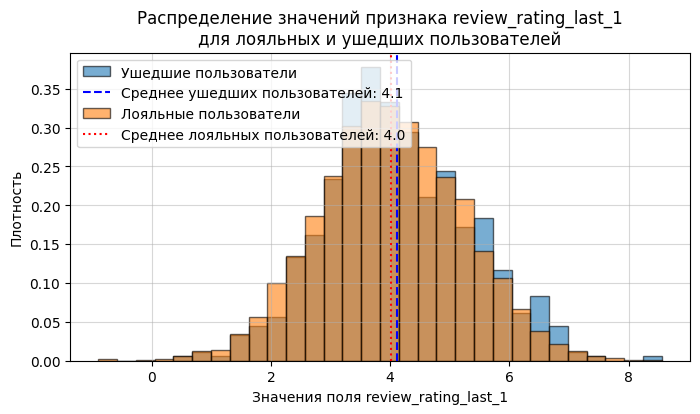

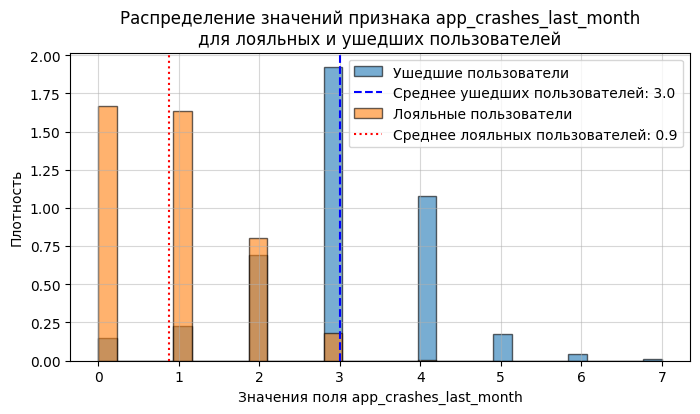

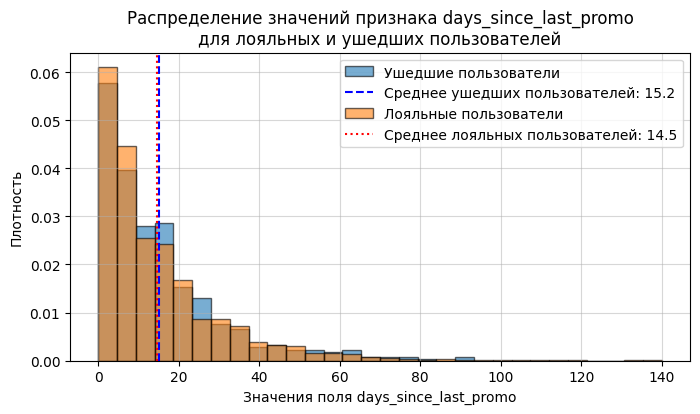

Статистики распределения значений признаков с числовыми данными:


,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,app_opens_per_week,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo
count,9505.000000,9850.000000,10062.000000,9867.000000,9619.000000,10156.000000,9506.000000,10053.000000,9554.000000,9757.000000,9593.000000,9729.000000,9719.000000
mean,4.394214,4.025666,0.930686,1063.741207,452.651500,1946.132979,413.004760,0.284446,11.330895,4.206709,4.022460,1.013362,14.554584
std,4.858757,2.826144,0.657261,707.713396,258.657571,2370.619590,445.634902,0.158735,14.528887,0.782212,1.207883,1.010342,15.308869
min,0.000000,0.011046,-0.169131,-32.075932,-10.353340,-43.716463,-2290.559468,0.002162,0.000000,1.415526,-0.897000,0.000000,0.000000
25%,1.000000,1.937767,0.445185,552.898663,262.908598,629.680382,136.565833,0.159884,6.313628,3.675543,3.214157,0.000000,4.000000
50%,3.000000,3.381094,0.784839,898.643524,406.456818,1300.409757,288.277327,0.264583,9.228383,4.203555,3.990032,1.000000,10.000000
75%,6.000000,5.439363,1.262350,1406.332153,590.418070,2481.650495,549.699420,0.387056,12.726649,4.717292,4.845225,2.000000,20.000000
max,40.000000,27.389318,6.302624,5901.965278,2189.101644,79298.849570,8615.988952,0.887301,224.587876,7.384425,8.558443,7.000000,140.000000


In [6]:
# Функция для сравнения плотностей распределения
def show_num_distribution(col,
                          bins_cnt=30,
                          title='',
                          xlabel='',
                          ylabel='Плотность',
                          figsize=(8,4)):
    
    # Устанавливаем общие границы бинов
    bins = np.histogram_bin_edges(df[col].dropna().to_numpy(), bins=bins_cnt)

    # Разделяем данные на серии
    series_1 = df[df['churn'] == 1][col] # ушедшие
    series_0 = df[df['churn'] == 0][col] # лояльные
    
    # Строим гистограммы плотностей распределения двух серий
    plt.figure(figsize=figsize)
    series_1.plot.hist(density=True,
                          bins=bins,
                          alpha=0.6,
                          edgecolor='k',
                          label=f'Ушедшие пользователи')
    plt.axvline(series_1.mean(), # добавляем среднее первой серии
                color='b',
                linestyle='--',
                linewidth=1.5,
                label=f"Среднее ушедших пользователей: \
{round(series_1.mean(),1)}")
    
    series_0.plot.hist(density=True,
                          bins=bins,
                          alpha=0.6,
                          edgecolor='k',
                          label='Лояльные пользователи')
    plt.axvline(series_0.mean(), # добавляем среднее второй серии
                color='r',
                linestyle=':',
                linewidth=1.5,
                label=f"Среднее лояльных пользователей: \
{round(series_0.mean(),1)}")

    plt.title(title if title != '' else
    f'Распределение значений признака {col}\n\
для лояльных и ушедших пользователей')
    plt.xlabel(xlabel if xlabel != '' else\
               f'Значения поля {col}')
    plt.ylabel(ylabel)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()
    
# Выводим гистограммы
for col in num_feat_list:
    show_num_distribution(col)

print('Статистики распределения значений признаков с числовыми данными:')
df[num_feat_list].describe()

- __review_rating_last_10 и review_rating_last_1__:
    - В этих полях распределение значений близкое к симметричному.
    - Большая часть оценок пользователей (как лояльных, так и ушедших) колеблется в районе 3-5 баллов.
    - В поле review_rating_last_1 встречаются __отрицательные оценки при чем в виде не целых чисел, а с несколькими знаками после запятой__. Учитывая то, что в этом поле содержится оценка последнего заказа пользователя, невозможно не задаться вопросом: в каком формате выставляются оценки пользователями, и каким образом они агрегируются в витрину. Корректность данных этого признака вызывает сомнения.
- __days_since_last_order, order_frequency_month и order_frequency_week__:
    - У всех трех признаков имеется длинных "хвост" справа в распределении.
    - Форма распределения у среднего количества заказов пользователя в месяц и неделю практически одинаковая.
    - В данных признака order_frequency_week имеются отрицательные значения. Это может говорить об ошибке, а может о нюансах в работе сервиса или обработки данных: например, сервис делает подарки клиентам и считает их заказами, при чем отрицательными. Как бы там ни было, к необходимости наличия этого признака в обучающих данных есть вопросы.
- __avg_order_value, median_order_value, total_spent_last_month, total_spent_last_week__:
    - У всех признаков имеется длинных "хвост" справа в распределении.
    - Усредненные значения среднего (1000) и медианного (450) чеков пользователей различаются более чем в 2 раза, что может говорить о большом разбросе значений стоимостей заказов. При этом у лояльных пользователей нет кардинальных различий в распределении среднего и медианного чеков по сравнению с ушедшими.
    - Все признаки содержат отрицательные значения. В поле total_spent_last_week отрицательные значения особенно большие по модулю, что можно объяснить наименьшей выбркой данных для агрегации этого поля: в остальных трех полях эти значения могут "теряться" за счет усреднения большего количества чеков.
    - В среднем за последний месяц и последнюю неделю ушедшие пользователи тратили больше, чем лояльные.
- __discount_usage_rate__:
    - Распределение асимметричное, смещено влево от центра, но правый хвост относительно небольшой.
    - Доля заказов со скидкой за последний месяц для большинства пользователей находится в диапазоне от 0.1 до 0.4.
- __app_opens_per_week__:
    - Распределение сильно асимметричное с длинным правым хвостом.
    - Большая часть значений сосредоточена в диапазоне от 0 до 20, однако встречаются редкие значения и в сотнях единиц.
    - Из гистограммы видно, что распределение среднего количества открытий приложения в месяц лояльных пользователей отличается от распределения ушедших. В среднем ушедшие открывают приложение чаще.
- __app_crashes_last_month__:
    - Для этого признака лучше подошла бы столбчатая диаграмма, но и по гистограмме видно на сколько сильно этот признак влияет на целевую переменную:
        - `0-1 зависание в месяц` - пользователи редко уходят, если количество зависаний не превышает 1;
        - `2 зависания в месяц` - видно, что лояльных пользователей с двумя зависаниями существенно меньше, чем с 0 или 1. В это же время на 2 зависания приходится заметная доля ушедших;
        - `3 зависания в месяц` - для большей части ушедших пользователей 3 зависания приложения в месяц становятся триггером к уходу, лояльных пользователей после трех зависаний правктически не остается;
        - `4+ зависания в месяц` - практически стопроцентная гарантия того, что пользователь уйдет.
    - Судя по всему, у этого признака очень высокая корреляция с целевой переменной.
- __days_since_last_promo__:
    - Распределение с длинным правым хвостом.
    - Судя по распределению и усредненным значениям, у лояльных пользователей в среднем прошло меньше дней с последнего использования промокода или акции чем у ушедших.

__Далее проверим рспределение значений в категориальных признаках:__

In [7]:
# Выводим информацию о распределении данных в столбцах с бинарными данными
def show_num_distribution(col):

    # количество строк, принадлежащей каждой из категорий столбца
    total_cnt = df[col].value_counts(dropna=False)
    total_cnt.name = 'total_count'

    # процент строк, принадлежащей каждой из категорий столбца
    total_perc = df[col].value_counts(normalize=True,
                                      dropna=False).round(4) * 100
    total_perc.name = 'total_percent'

    # количество и процент строк каждой из категорий столбца,
    # в которых целевая переменная положительна
    positive_target = df.groupby(col, dropna=False).agg(
        positive_target_count = ('churn', 'sum'),
        positive_target_percent = ('churn', 'mean')
    )

    # объединяем данные
    cat_df = pd.concat([total_cnt,
                       total_perc,
                       positive_target], axis=1)
    
    # переводим доли положительной целевой переменной в проценты
    cat_df['positive_target_percent'] =\
        cat_df['positive_target_percent'].round(4) * 100

    # выводим датафрейм
    print(f'Распределение значений в поле {col}')
    if cat_df.shape[0]<=10:
        display(cat_df)
    else:
        display(cat_df.head(10))
        display(cat_df.tail(10))
        print(f'Общее количество классов признака {col}: {cat_df.shape[0]}')
    print()

for col in cat_feat_list:
    show_num_distribution(col)

Распределение значений в поле last_coffee_type


,total_count,total_percent,positive_target_count,positive_target_percent
last_coffee_type,,,,
arabica,6134,58.70,351,5.72
robusta,2524,24.15,167,6.62
blend,1534,14.68,93,6.06
NaN,258,2.47,18,6.98



Распределение значений в поле preferred_roast


,total_count,total_percent,positive_target_count,positive_target_percent
preferred_roast,,,,
medium,3458,33.09,210,6.07
light,3453,33.04,207,5.99
dark,3423,32.76,208,6.08
NaN,116,1.11,4,3.45



Распределение значений в поле milk_preference


,total_count,total_percent,positive_target_count,positive_target_percent
milk_preference,,,,
whole,2876,27.52,178,6.19
oat,1982,18.97,118,5.95
almond,1483,14.19,97,6.54
skim,1451,13.89,85,5.86
none,1015,9.71,56,5.52
soy,975,9.33,55,5.64
NaN,668,6.39,40,5.99



Распределение значений в поле coffee_bean_origin


,total_count,total_percent,positive_target_count,positive_target_percent
coffee_bean_origin,,,,
ethiopia,1690,16.17,99,5.86
kenya,1646,15.75,89,5.41
vietnam,1635,15.65,92,5.63
guatemala,1621,15.51,101,6.23
brazil,1596,15.27,104,6.52
colombia,1580,15.12,101,6.39
NaN,682,6.53,43,6.30



Распределение значений в поле last_drink_size


,total_count,total_percent,positive_target_count,positive_target_percent
last_drink_size,,,,
medium,4925,47.13,285,5.79
large,2997,28.68,184,6.14
small,2024,19.37,118,5.83
NaN,504,4.82,42,8.33



Распределение значений в поле subscription_status


,total_count,total_percent,positive_target_count,positive_target_percent
subscription_status,,,,
none,3803,36.39,191,5.02
basic,2862,27.39,154,5.38
premium,1923,18.40,135,7.02
NaN,938,8.98,49,5.22
pro,924,8.84,100,10.82



Распределение значений в поле seasons


,total_count,total_percent,positive_target_count,positive_target_percent
seasons,,,,
spring,2507,23.99,159,6.34
autumn,2433,23.28,141,5.80
winter,2423,23.19,138,5.70
summer,2408,23.04,137,5.69
NaN,679,6.50,54,7.95



Распределение значений в поле phone_type


,total_count,total_percent,positive_target_count,positive_target_percent
phone_type,,,,
android,4611,44.12,301,6.53
ios,4502,43.08,258,5.73
web,1001,9.58,58,5.79
NaN,336,3.22,12,3.57



Распределение значений в поле geo_location


,total_count,total_percent,positive_target_count,positive_target_percent
geo_location,,,,
geo_2,1629,15.59,118,7.24
geo_3,1573,15.05,87,5.53
geo_1,1532,14.66,80,5.22
geo_99,117,1.12,7,5.98
geo_95,110,1.05,10,9.09
NaN,110,1.05,7,6.36
geo_92,108,1.03,5,4.63
geo_93,98,0.94,10,10.20
geo_96,97,0.93,3,3.09


,total_count,total_percent,positive_target_count,positive_target_percent
geo_location,,,,
geo_80,44,0.42,2,4.55
geo_78,44,0.42,1,2.27
geo_7,44,0.42,4,9.09
geo_82,43,0.41,2,4.65
geo_51,43,0.41,3,6.98
geo_41,42,0.40,2,4.76
geo_45,41,0.39,2,4.88
geo_55,41,0.39,4,9.76
geo_60,40,0.38,2,5.00


Общее количество классов признака geo_location: 101



- __last_coffee_type__:
    - Чаще всего последним купленным типом кофе был `arabica` (59%). Доля ушедших клиентов, выбравших этот тип - наименьшая.
    - Наибольшая доля ушедших - те, у кого тип не указан.
- __preferred_roast__:
    - Распределение практически равномерное (среди тех, кого указан предпочитаемый тип обжарки).
    - Доля уходов меньше всего у тех, у кого нет данных в этом поле.
- __milk_preference__:
    - Чаще выбирают `whole`, реже - `soy`.
    - Доля уходов больше всего у предпочитающих `almond`.
- __coffee_bean_origin__:
    - Распределение близкое к равномерному.
    - Однако, если выделить 3 наиболее популярных страны происходения кофе (ethiopia, kenya, vietnam) - доля уходов среди предпочитающих кофе из этой страны немного ниже, чем у предпочитающих другие страны (и тех, у кого страна не указана).
- __last_drink_size__:
    - Чаще всего последний заказ был средним по размеру (47%).
    - Доля уходов больше всего у тех, у кого размер заказа не был указан.
- __subscription_status__:
    - Есть 4 вида подписок.
    - Большинство пользователей либо без подписки, либо с подпиской типа `basic`.
    - Наименее популяная подписка `pro`. У пользователей с этой подпиской наибольшая доля уходов.
- __seasons__:
    - Признак содержит все 4 времени года. Учитавая тот факт, что наблюдения представлены за 4 недели, а признак должен показывать "текущее время года", должно быть только 2 варината.
    - Это второй кандидат на удаление из обучающих данных (после `user_id`), так как даже в случае наличия корреляции с целевой переменной, на мой взгляд, оставлять его опасно - непонятно что за данные агрегируются в это поле и каким образом.
- __phone_type__:
    - Учитываются 3 вида устройств:
        - большая часть приходитс на `android` (44%) и `ios` (43%)
        - на `web` приходится менее 10%
    - Чаще уходят пользователи `android`. Реже - те, у кого не указан тип устройства.
- __geo_location__:
    - Количество регионов пользователей, представленных в данных: 100.
    - Больше половины пользователей принадлежат десяти самым популярным регионам.

__Промежуточные итоги:__
- Проверено распределение значений в бинарных, числовых и категориальных признаках.
- Сделаны предварительные выводы и предположения о том, как целевая переменная связана с распределеним данных в признаках.
- Принято решение удалить поле `user_id`и `seasons`. Первая в принципе не нужна для обучения, а вторая не соответсвует логике, указанной в описании данных.

In [8]:
df = df.drop(columns=['user_id', 'seasons']).copy()
cat_feat_list.remove('seasons')

Признаки удалены, идем дальше.

### 2.4. Пропущенные значения

Сначала рассмотрим __бинарные признаки__.

Напишем формулу, которая будет для каждого признака выводить количество (`na_count`) и процент (`na_percent`) пропусков, а так же долю ушедших клиентов среди тех, у кого пропуск в соответствующем поле (`positive_target_perc`).  
Так же посчитаем процент отклонения этой доли от среднего значени по наблюдениям (`percent_of_diff`), которое составляет примерно 6.02%.

In [9]:
def missing_value_info(col_list):

    # Количество пропусков
    missimg_series = df[col_list].isna().sum()

    # Датафрейм с количеством пропусков в абсолютных и относительных значен.
    missimg_df = pd.concat([missimg_series,
                            round(missimg_series/df_shape[0], 4) * 100],
                            axis=1)
    missimg_df.columns = ['na_count', 'na_percent']
    
    # Доля ушедших пользователей среди клиентов с пропуском в поле
    missimg_df['positive_target_perc'] =\
    [df[df[col].isna()]['churn'].mean() for col in col_list]
    
    # Отношение отклонения это доли к среднему значению
    missimg_df['percent_of_diff'] =\
    (missimg_df['positive_target_perc']-df['churn'].mean())/df['churn'].mean()

    # Перевод долей в проценты
    missimg_df[['positive_target_perc','percent_of_diff']] =\
    missimg_df[['positive_target_perc','percent_of_diff']].round(4) * 100

    display(missimg_df)


missing_value_info(bi_feat_list)

,na_count,na_percent,positive_target_perc,percent_of_diff
seasonal_menu_tried,989,9.46,4.55,-24.41
notifications_enabled,537,5.14,6.15,2.10
coffee_preference_change,610,5.84,6.72,11.67


__Стратегия обработки пропусков в бинарных признаках:__
- Признаки `seasonal_menu_tried` и `coffee_preference_change` придется перевести в категориальные, заменив пропуски на индикатор (например "missing") так как доля уходов пользователей с пропусками в этих полях существенно отличается от средней.
- В поле `notifications_enabled` пропуски можно заменить на 0 так как доля уходов у таких клиентов близка и к средней, и к доле ушедших пользователей, у которых уведомления выключены (класс 0) (см. пункт 2.3). 

Переходим к __числовым признакам__:

In [10]:
missing_value_info(num_feat_list)

,na_count,na_percent,positive_target_perc,percent_of_diff
days_since_last_order,945,9.04,6.14,1.97
order_frequency_month,600,5.74,8.00,32.91
order_frequency_week,388,3.71,5.41,-10.08
avg_order_value,583,5.58,7.55,25.39
median_order_value,831,7.95,6.98,15.96
total_spent_last_month,294,2.81,7.48,24.32
total_spent_last_week,944,9.03,6.99,16.15
discount_usage_rate,397,3.80,7.30,21.36
app_opens_per_week,896,8.57,5.13,-14.71
review_rating_last_10,693,6.63,5.34,-11.30


Судя по значениям таблицы выше (доля ушедших среди наблюдений с пропущенными значениями отличается от среднего значения), помимо заполнения пропусков для каждого числового признака нужно добавить дополнительный индикатор пропуска чтобы модель могла отличить настоящие значения от предполагаемых и учесть влияние таких значений на прогноз.

Сами пропуски __будем заменять либо на медиану__ (так как для большинства признаков среднее может быть сильно смещено из-за выбросов), __либо на 0__.

- Пропуски в полях __app_crashes_last_month__ и __discount_usage_rate__ заменяем на 0:
    - Так как доля ушедших среди клиентов с пропусками в поле __app_crashes_last_month__ ниже средней, то можно предположить, что количество зависаний у таких клиентов меньше среднего. Дополнительный индикатор поможет модели отличить реальное отсутсвие зависаний от отсутсвия данных в этом поле.
    - В поле __discount_usage_rate__ не встречаются нулевые значения, поэтому логично предположить, что пропуск может означать именно 0 - отсутствие заказов с применением скидок.
- В остальных числовых полях заменяем пропуски на медиану.
- Для всех полей с числовыми данными добавляем индикаторы пропусков.

Переходим к __категориальным признакам__:

In [11]:
missing_value_info(cat_feat_list)

,na_count,na_percent,positive_target_perc,percent_of_diff
last_coffee_type,258,2.47,6.98,15.91
preferred_roast,116,1.11,3.45,-42.71
milk_preference,668,6.39,5.99,-0.52
coffee_bean_origin,682,6.53,6.30,4.75
last_drink_size,504,4.82,8.33,38.45
subscription_status,938,8.98,5.22,-13.21
phone_type,336,3.22,3.57,-40.67
geo_location,110,1.05,6.36,5.72


- Процент пропусков в категориальных столбцах варьируется в границах от 1% до 9%.
- Все пропуски заменим на индикатор `missing`.

__Промежуточные итоги:__
- Определена стратегия обработки пропусков для признаков каждого типа.
- Решено оставить все строки, заменяя пропуски на медиану, ноль или значение-индикатор. Для столбцов с числовыми данными добавим признаки-индикаторы пропусков.

### 2.5. Категориальные признаки. Кодирование

In [12]:
df[cat_feat_list].describe()

,last_coffee_type,preferred_roast,milk_preference,coffee_bean_origin,last_drink_size,subscription_status,phone_type,geo_location
count,10192,10334,9782,9768,9946,9512,10114,10340
unique,3,3,6,6,3,4,3,100
top,arabica,medium,whole,ethiopia,medium,none,android,geo_2
freq,6134,3458,2876,1690,4925,3803,4611,1629


Так как линейные модели работают толко с числовыми значениями, для всех категориальных признаков, использующихся для обучения, необходимо выбрать способ кодирования.
- Все категориальные признаки с количеством уникальных значений, не превышающих 10, будем кодировать с помощью класса OneHotEncoder.
- Признак `geo_location` будем кодировать тоже с помощью OneHotEncoder, но с использованием параметра __min_frequency__ для того, чтобы не грузить модель ненужными признаками: у некоторых регионов количество пользователей не превышает 50 человек (см. пункт 2.3) - это довольно небольшая выборка. Поэтому будем использовать начальное значение `min_frequency = 50`. На этапе подбора гиперпараметров, возможно, проверим модель с другими значениями этого гиперпараметра.

Есть желание закодировать `subscription_status`, присвоив значению none - 0, значению basic - 1 и так далее (а так же поля `last_drink_size` и `preferred_roast`). Но я не до конца понимаю нюансы такого преобразования (в теории об этом было мало) поэтому отложим этот вид кодировки до лучших времен.

Пункт задания про "можно ли использовать некоторые из них для генерации новых  признаков": если он относится именно к категориальным признакам, то не представляю как их можно использовать для генерации новых признаков.

### 2.6. Выбросы

Построим ящики с усами для всех числовых признаков:

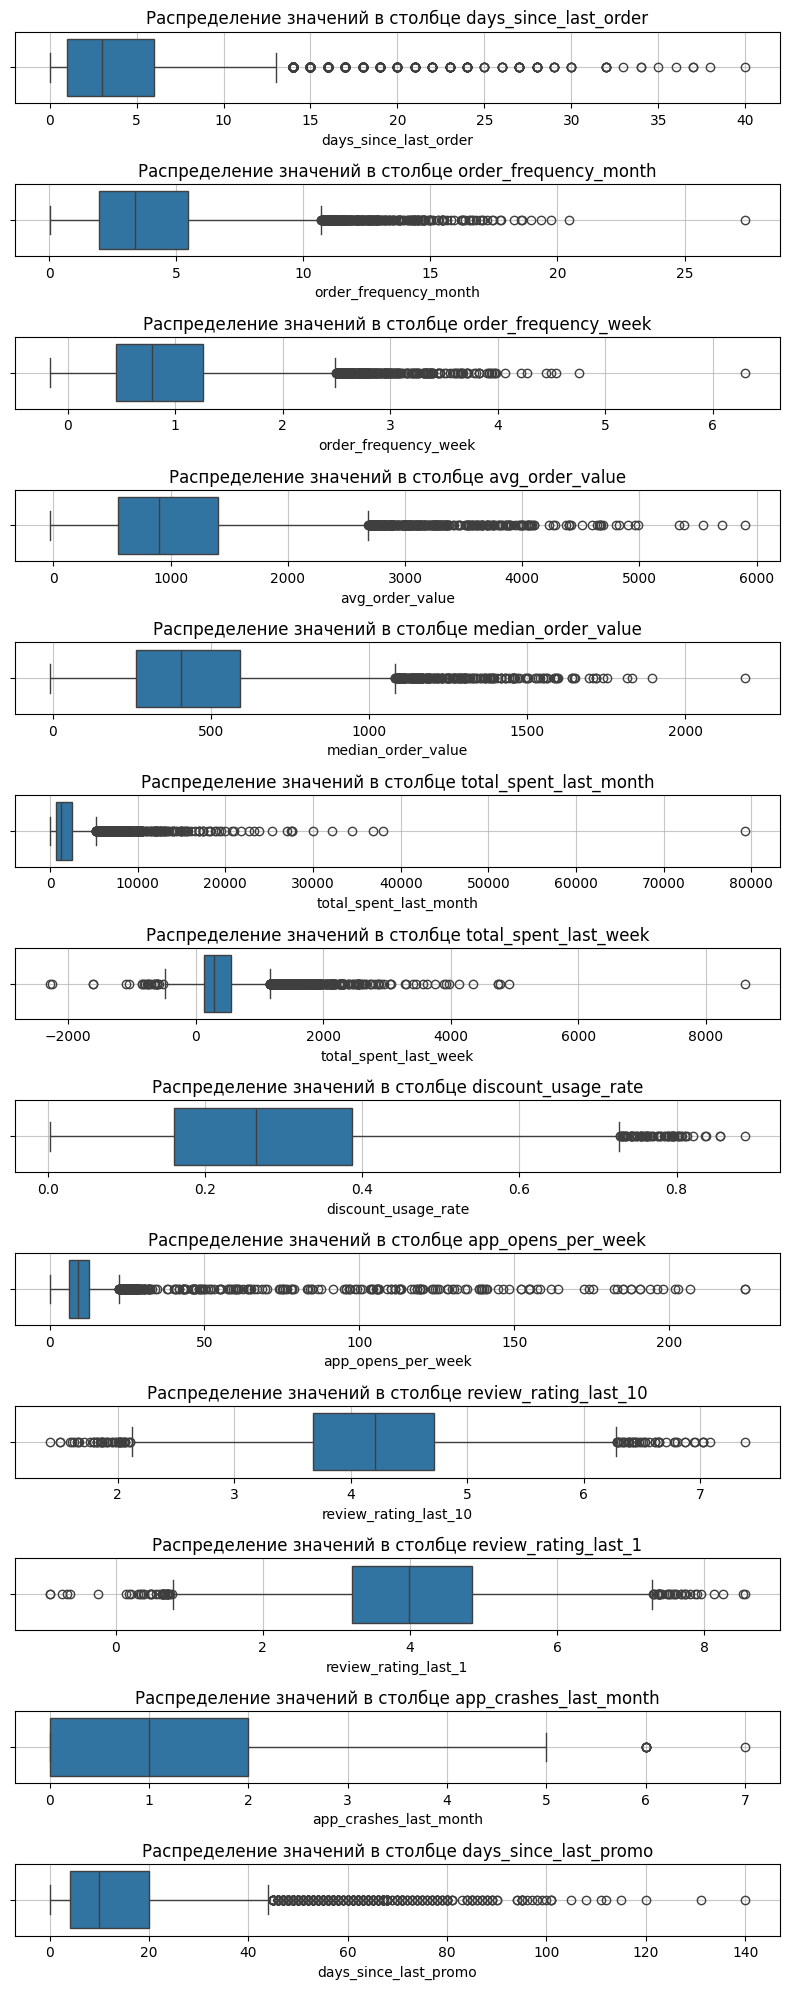

In [13]:
plt.figure(figsize=(8,20))
for i, col in enumerate(num_feat_list):
    plt.subplot(13,1,i+1)
    sns.boxplot(data=df[col], orient='h')
    plt.title(f'Распределение значений в столбце {col}')
    plt.grid(alpha=.7)
plt.tight_layout()
plt.show()

Ящики с усами показывают большое количество выбросов почти во всех признаках. Однако, в большинстве случаев это просто вариативность данных, а не аномалии - с этим можно работать (можно использовать логарифм или квадратный корень).  
И все же в несокольких полях есть очень большие отклонения о среднего и медианы, которые могут сильно искажать картину. Поэтому удалим строки с экстремально большими значениями в следующих полях:
- order_frequency_month;
- order_frequency_week;
- total_spent_last_month;
- total_spent_last_week.

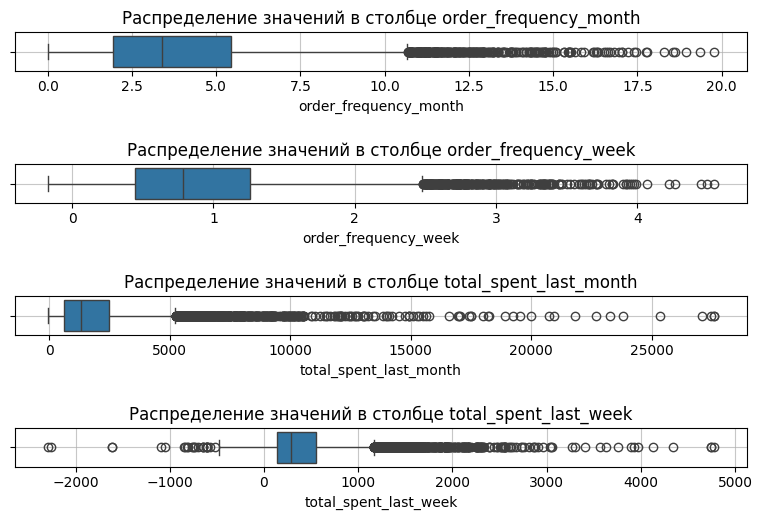

Количество удаленных строк: 8
Количество строк в датафрейме после удаления: 10442


In [14]:
# Список для удаления экстремальных масимальных значений
drop_max_list = ['order_frequency_month',
            'order_frequency_week',
            'total_spent_last_month',
            'total_spent_last_week']

# Удаляем строки с экстремальными значениями
df = df[((df['order_frequency_month'] <= 20) |
                (df['order_frequency_month'].isna())) &
        ((df['order_frequency_week'] <= 5) |
                (df['order_frequency_week'].isna())) &
        ((df['total_spent_last_month'] <= 30000) |
                (df['total_spent_last_month'].isna())) &
        ((df['total_spent_last_week'] <= 5000) |
                (df['total_spent_last_week'].isna()))].reset_index(drop=True)

# Повторно смотрим выбросы
plt.figure(figsize=(8,17))
for i, col in enumerate(drop_max_list):
    plt.subplot(13,1,i+1)
    sns.boxplot(data=df[col], orient='h')
    plt.title(f'Распределение значений в столбце {col}')
    plt.grid(alpha=.7)
plt.tight_layout(pad=2.0)
plt.show()

print(f'Количество удаленных строк: {df_shape[0] - df.shape[0]}')
print(f'Количество строк в датафрейме после удаления: {df.shape[0]}')

С остальными выбросами будем работать при создании новых признаков путем взятия логарифма или квадратного корня, так как эти значения не похожи на ошибки, а скорее представляют клиентов, которые закупают кофе для небольших заведений общепита.

На ящиках с усами (так же как и на гистограммах из пункта 2.3) бросаются в глаза отрицательные значения, их не очень много, но они есть. Можно было бы их удалить, но нет гарантии, что это ошибки. Во всяком случае, им можно придумать обоснование. К тому же при взятии корня или логарифма эти значения будут приравниваться к небольшому положительному числу. А отрицательные значения из поля total_spent_last_week вообще можно попробовать вынести в отдельный признак (на соответствующем этапе).

__Промежуточные итоги:__
- Практически во всех полях с числовым типом данных присутствует значительное количество выбросов, что было видно еще в пункте 2.3. Там было видно, что почти во всех полях среднее заметно смещено относительно медианы, а стандартное отклонение иногда в несколько раз превышает среднее (исключения - поля с оценками, там распределение почти симметричное).
- Лишний раз убедились, что для заполнения пропусков лучше использовать медиану, а не среднее.
- Так как значения имеют разный масштаб, треубется стандартизация данных.

### 2.7. Корреляция

Для расчета коэффициентов корреляции воспользуемся матрицей __phik__, которая может вычислять коэффициенты в том числе и для категориальных значений:

In [15]:
# Создаем матрицу корреляции
corr_matrix = df.phik_matrix(interval_cols=[col for col in num_feat_list\
                                            if col not in [
                                                'app_crashes_last_month',
                                                'days_since_last_order',
                                                'days_since_last_promo'
                                            ]])

# Строим тепловую карту коэффициентов корреляции
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False)
plt.title('Тепловая карта коэффициентов корреляции признаков')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'phik_matrix'

- Самый большой коэффициент корреляции с целевой переменной у количества зависаний приложения, как и предполагалось.
- Между собой коррелируют признаки, описывающие поведение пользователей в разрезе месяца и недели (заканчивающиеся на '_month' и '_week'), что закономерно.
- Сильнее всего между собой коррелируют order_frequency_month и order_frequency_week. Можно заполнить пропуски в стобце _month умножая значения из _week на среднее количество недель в месяце, которое рассчитаем разделив среднее количество дней в месяце (30,43) на 7. После этой манипуляции оставим бинарный признак, сигнализирующий о том, что значение в order_frequency_month расчетное. Все это сделаем частью обучающего пайплайна на соответствующем этапе.
- Все остальные признаки будем пробовать для обучения не смотря на нулевые значения корреляции.

### 2.8. Результаты EDA

- Познакомились с данными.
- Проверили полные дубликаты.
- Посмотрели распределение значений признаков и целевой переменной.
- Выбрали стратегию обработки пропусков и выбрасов и кодирования категориальных признаков.
- Удалили бесполезные для обучения признаки и строки с экстремальными значениями.
- Проверили корреляцию признаков между собой и с целевой переменной.

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



### 3.1. Разделение данных на выборки

In [ ]:
# Отделяем целевую переменную от признаков
X = df.drop(columns='churn').copy()
y = df['churn'].copy()

# Разделяем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=r_s)

# Проверяем размеры
print('Размеры выборок:')
print(f'Train:\tX = {X_train.shape}\ty = {y_train.shape}')
print(f'Test:\tX = {X_test.shape}\ty = {y_test.shape}')

Размеры выборок:
Train:	X = (8353, 24)	y = (8353,)
Test:	X = (2089, 24)	y = (2089,)


### 3.2. Предобработка данных с помощью класса Pipeline

В начале напишем функцию для заполнения пропусков в `order_frequency_month` на основе данных `order_frequency_week` с добавлением индикатора заполнения, а также создадим списки с наименованиями полей для обработки в соответствующих пайплайнах.

Далее __добавим следующие пайплайны:__
1. Обработка числовых столбцов, в которых нужно заменить пропуски на ноль (`notifications_enabled`, `app_crashes_last_month` и `discount_usage_rate`).
2. Обработка остальных числовых столбцов, в которых нужно заменить пропуски на медиану.
3. Все категориальные признаки, включая `seasonal_menu_tried` и `coffee_preference_change`.

Для масштабирования числовых признаков будем использовать класс MinMaxScaler.

In [ ]:
# Функция для конвертации частоты заказов из недельной в месячную
def order_frequency_convert(X: pd.DataFrame):
    X = X.copy()

    # Коэффициент конвертации (среднее количество недель в месяце)
    coeff = 30.43/7

    # Создаем маску для строк, где нужно заполнить пропуски
    mask = (X["order_frequency_month"].isna() &
            X["order_frequency_week"].notna())
    
    # Заполняем пропуски
    X.loc[mask, 'order_frequency_month'] = X.loc[mask,
                                                'order_frequency_week'] * coeff

    # Добавляем индикатор заполнения пропусков
    X['order_frequency_month_imputed'] = mask.astype("int8")

    # Здесь же переводим seasonal_menu_tried и coffee_preference_change
    # в категориальные признаки и заполняем в них пропуски
    bi_to_cat_cols = ['seasonal_menu_tried', 'coffee_preference_change']

    X[bi_to_cat_cols] = X[bi_to_cat_cols].where(pd.notnull(X[bi_to_cat_cols]),
                                                'missing').astype('string')
    
    return X.drop(columns='order_frequency_week')

# Список числовых признаков, в которых пропуски будут заполнены нулями
zero_num_col = ['notifications_enabled',
                'app_crashes_last_month',
                'discount_usage_rate']

# Список числовых признаков, в которых пропуски будут заполнены медианной
median_num_col = [col for col in num_feat_list if col not in zero_num_col]

# Удаляем 'order_frequency_week' из списка median_num_col и
# добавляем 'order_frequency_month_imputed'
median_num_col[median_num_col.index('order_frequency_week')]\
    = 'order_frequency_month_imputed'

# Список категориальных признаков (кроме geo_location)
# включая seasonal_menu_tried и coffee_preference_change
cat_col = [col for col in cat_feat_list + bi_feat_list
           if col not in ['notifications_enabled']]

Нужно убедиться, что все необходимые поля попали в списки, а лишние не попали:

In [ ]:
print(f'Признаки, которые есть в датасете, но нет в списках:')
print([col for col in X.columns
       if col not in cat_col+median_num_col+zero_num_col])
print(f'Признаки, которые есть в списках, но нет в датасете:')
print([col for col in cat_col+median_num_col+zero_num_col
       if col not in X.columns])

Признаки, которые есть в датасете, но нет в списках:
['order_frequency_week']
Признаки, которые есть в списках, но нет в датасете:
['order_frequency_month_imputed']


Ошибок нет:
- `order_frequency_month_imputed` будет создаваться в финальном пайплайне, а `order_frequency_week` наоборот.

Переходим к пайплайнам:

In [ ]:
# 1. Обработка числовых признаков с заполнением пропусков нулями
zero_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',
                              add_indicator=True,
                              fill_value=0)),
    ('scaler', MinMaxScaler())
])

# 2. Обработка числовых признаков с заполнением пропусков медианой
median_num_pipeline = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', MinMaxScaler())
])

# 3. Обработка категориальных признаков
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', min_frequency=50))
])

__Промежуточные итоги:__
- Написана функция конвертации усредненного еженедельного количества заказов в ежемесяченое для заполнения пропусков.
- Собраны списки с названием полей для обработки в соответсвующих пайплайнах.
- Написаны пайплайны для обработки каждой категории полей.

## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

### 4.1. Обучение базовой модели

Соберем трансформер из пайплайнов для обработки всех признаков:

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('zero_num', zero_num_pipeline, zero_num_col),
    ('median_num', median_num_pipeline, median_num_col),
    ('cat', cat_pipeline, cat_col)
])

Создаем словарь для записи в него параметров моделей и метрик качества их работы:

In [ ]:
# Словарь для фиксирования параметров и метрик качества каждой обученной модели
results = {
    'features_type': [], # вид признаков (normal / enhanced / filtered)
    'model_name': [], # название модели
    'precision': [],
    'precision_std': [],
    'recall': [],
    'recall_std': [],
    'f1': [],
    'f1_std': [],
    'roc_auc': [],
    'roc_auc_std': [],
    'pr_auc': [],
    'pr_auc_std': []
}

# Функция для удобного добавления моделей и их параметров в словарь results
def append_model(features_type, model_name, precision,
                 recall, f1, roc_auc, pr_auc, precision_std=None,
                 recall_std=None, f1_std=None, roc_auc_std=None,
                 pr_auc_std=None):
    results['features_type'].append(features_type)
    results['model_name'].append(model_name)
    results['precision'].append(precision.mean().round(4)
                                if precision_std==None else round(precision, 4))
    results['recall'].append(recall.mean().round(4)
                             if recall_std==None else round(recall, 4))
    results['f1'].append(f1.mean().round(4)
                             if f1_std==None else round(f1, 4))
    results['roc_auc'].append(roc_auc.mean().round(4)
                             if roc_auc_std==None else round(roc_auc, 4))
    results['pr_auc'].append(pr_auc.mean().round(4)
                             if pr_auc_std==None else round(pr_auc, 4))
    results['precision_std'].append(precision.std().round(4)
                             if precision_std==None else round(precision_std, 4))
    results['recall_std'].append(recall.std().round(4)
                             if recall_std==None else round(recall_std, 4))
    results['f1_std'].append(f1.std().round(4)
                             if f1_std==None else round(f1_std, 4))
    results['roc_auc_std'].append(roc_auc.std().round(4)
                             if roc_auc_std==None else round(roc_auc_std, 4))
    results['pr_auc_std'].append(pr_auc.std().round(4)
                             if pr_auc_std==None else round(pr_auc_std, 4))

В качестве базовой модели будем использовать `DummyClassifier`. Также обучим модель класса `LogisticRegression` чтобы потом сравнить ее метрики с метриками модели, обученной на данных с новыми признаками.

In [ ]:
# Итоговый пайплайн для обучения DummyClassifier:
dummy_pipeline = Pipeline(steps=[
    ('convert', FunctionTransformer(order_frequency_convert, validate=False)),
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(random_state=r_s))
])

# Итоговый пайплайн для обучения LogisticRegression:
logistic_pipeline = Pipeline(steps=[
    ('convert', FunctionTransformer(order_frequency_convert, validate=False)),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=r_s))
])

# Задаем разделение выборки и вычисляемые метрики
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=r_s)
scoring = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision']

# Обучаем DummyClassifier и фиксируем метрики
dummy_scores = cross_validate(
    estimator=dummy_pipeline,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv
)

append_model('normal',
             'DummyClassifier()',
             dummy_scores['test_precision'],
             dummy_scores['test_recall'],
             dummy_scores['test_f1'],
             dummy_scores['test_roc_auc'],
             dummy_scores['test_average_precision'])

# То же самое делаем для LogisticRegression

logistic_scores = cross_validate(
    estimator=logistic_pipeline,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv
)

append_model('normal',
             'LogisticRegression()',
             logistic_scores['test_precision'],
             logistic_scores['test_recall'],
             logistic_scores['test_f1'],
             logistic_scores['test_roc_auc'],
             logistic_scores['test_average_precision'])

/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predi

### 4.2. Метрики базовой модели

Выведем полученные метрики:

In [ ]:
display(pd.DataFrame(results))

,features_type,model_name,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
0,normal,DummyClassifier(),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0602,0.0003
1,normal,LogisticRegression(),0.8535,0.0586,0.3997,0.0406,0.5432,0.0432,0.9338,0.0187,0.6725,0.0328


- Дамми модель бесполезна:
    - __F1__ = 0 - ничего не обобщила, не в состоянии ничего предсказать;
    - __ROC-AUC__ = 0.5 - наихудший результат;
    - __PR-AUC__ = 0.06 - по сути это процен положительного класса в выборке.

- LogisticRegression справляется неплохо:
    - __F1__ = 0.54 ± 0.04 невысокий результат из-за низкого Recall = 0.4 - модель находит только 40% ушедших клиентов;
    - __ROC-AUC__ = 0.93 - хороший результат, модель редко ошибается, если определеят класс как положительный;
    - __PR-AUC__ = 0.67 - для данных, с сильным дисбалансом это неплохой результат - эта модель находит уходящих клиентов в 11 раз лучше, чем базовая дамми;
    - Стандартные отклонения метрик находятся в диапазоне от 0.02 до 0.06, что говорит о достаточно неплохой стабильности.

## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

### 5.1. Новые признаки

1. `avg_month_spent_ln` - натуральный логарифм произведения среднемесячной частоты заказов (order_frequency_month) на среднюю сумму заказа (avg_order_value);
2. `total_spent_last_month_ln` - натуральный логарифм суммы, которую пользователь потратил за последний месяц;
3. `last_and_avg_spent_ratio` - отношение суммы, потраченной пользователем в последний месяц, к среднемесячной;
4. `total_spent_last_week_sqrt_pos` - квадратный корень положительных значений суммы, которую пользователь потратил за последний месяц;
5. `total_spent_last_week_sqrt_neg` - квадратный корень модуля отрицательных значений суммы, которую пользователь потратил за последний месяц;
6. `app_opens_per_week_sqrt` - квадратный корень среднего количества открытий приложения в неделю.

In [ ]:
def new_features_create(X: pd.DataFrame) -> pd.DataFrame:
    
    # Обрабатываем данные ранее написанной функцией
    X = order_frequency_convert(X)

    # Добавляем 6 новых признаков
    # 1
    X['avg_order_spent_ln'] = np.where(
        X['avg_order_value'].isna() | X['order_frequency_month'].isna(),
        np.nan,
        np.log(np.clip(X['avg_order_value'] * X['order_frequency_month'],
                       1,
                       np.inf))
    )

    # 2
    X['total_spent_last_month_ln'] = np.log(np.clip(X['total_spent_last_month'],
                                                    1,
                                                    np.inf))
    # 3
    X['last_and_avg_spent_ratio'] = X['total_spent_last_month_ln']/\
                                    X['avg_order_spent_ln'].replace(0, np.nan)
    
    # 4 и 5
    # Оставляем пропуски только в total_spent_last_week_sqrt_pos
    mask_pos = (X['total_spent_last_week'] >= 0) |\
        (X['total_spent_last_week'].isna())

    # Чтобы обойтись без лишних предупреждающих сообщений будем игнорировать
    # значения NaN, которые возникают при попытке взять корень от NaN
    with np.errstate(invalid='ignore'):
        # 4
        X['total_spent_last_week_sqrt_pos'] = np.where(
            mask_pos,
            np.sqrt(X['total_spent_last_week']),
            0
        )

    # 5
    X['total_spent_last_week_sqrt_neg'] = np.where(
        ~mask_pos,
        np.sqrt(X['total_spent_last_week'].abs()),
        0
    )

    # 6
    X['app_opens_per_week_sqrt'] = np.sqrt(X['app_opens_per_week'].abs())

    return X

### 5.2. Обучение модели на данных с новыми признаками

Добавим в списки с наименованием числовых признаков названия новых признаков:

In [ ]:
# Список числовых признаков, в которых пропуски будут заполнены медианной
median_num_col += ['app_opens_per_week_sqrt',
                   'avg_order_spent_ln',
                   'total_spent_last_month_ln',
                   'last_and_avg_spent_ratio',
                   'total_spent_last_week_sqrt_pos',
                   'total_spent_last_week_sqrt_neg']

Напишем новый пайплайн с использованием новой функции по добавлению признаков (new_features_create):

In [ ]:
log_pipe = Pipeline(steps=[
    ('new_features_create', FunctionTransformer(new_features_create,
                                                validate=False)),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=r_s))
])

log_scores_enhanced = cross_validate(
    estimator=log_pipe,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv
)

append_model('enhanced',
             'LogisticRegression()',
             log_scores_enhanced['test_precision'],
             log_scores_enhanced['test_recall'],
             log_scores_enhanced['test_f1'],
             log_scores_enhanced['test_roc_auc'],
             log_scores_enhanced['test_average_precision'])
display(pd.DataFrame(results))

,features_type,model_name,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
0,normal,DummyClassifier(),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0602,0.0003
1,normal,LogisticRegression(),0.8535,0.0586,0.3997,0.0406,0.5432,0.0432,0.9338,0.0187,0.6725,0.0328
2,enhanced,LogisticRegression(),0.8424,0.0439,0.4017,0.0379,0.5430,0.0390,0.9366,0.0191,0.6806,0.0350


__Промежуточные итоги:__
- Получилось немного улучшить почти все метрики кроме Precision.
- Стандартные отклонения большинства метрик уменьшились, что говорит о большей стабильности модели. Однако у ROC-AUC и PR-AUC стандартные отклонения немного выросли.  
В целом точность предсказаний модели увеличилась, но незначительно.

### 5.3. Определение важности признаков

Проверим величину коэффициентов модели:

In [ ]:
# Обучаем модель на всех данных
log_pipe.fit(X_train, y_train)

# Записываем в датафрейм веса каждого признака
coef_df=pd.DataFrame(
    {'name':log_pipe.named_steps['preprocessor'].get_feature_names_out(),
     'coef':log_pipe.named_steps['model'].coef_.ravel()})

# Добавляем процент отклонения веса каждого признака от среднего значения
# весов в процентах
coef_df['diff_perc'] = ((np.abs(coef_df['coef']/np.mean(coef_df['coef'])) -1)\
                        * 100).round(1)

# Сортируем по убыванию процента отклонения от среднего
coef_df=coef_df.sort_values('diff_perc', ascending=False)
print('30 признаков с наибольшими весами:')
display(coef_df.head(30))
print('30 признаков с наменьшими весами:')
display(coef_df.tail(30))

30 признаков с наибольшими весами:


,name,coef,diff_perc
1,zero_num__app_crashes_last_month,11.882579,7267.3
17,median_num__app_opens_per_week_sqrt,4.079227,2429.1
4,zero_num__missingindicator_app_crashes_last_month,3.299826,1945.9
7,median_num__order_frequency_month,2.026696,1156.6
11,median_num__total_spent_last_month,-1.378307,754.6
21,median_num__total_spent_last_week_sqrt_pos,1.005770,523.6
101,cat__geo_location_geo_98,-0.943982,485.3
96,cat__geo_location_geo_93,0.800760,396.5
90,cat__geo_location_geo_8,-0.757970,369.9
20,median_num__last_and_avg_spent_ratio,-0.722980,348.3


30 признаков с наменьшими весами:


,name,coef,diff_perc
18,median_num__avg_order_spent_ln,-0.085742,-46.8
32,median_num__missingindicator_days_since_last_promo,-0.073977,-54.1
25,median_num__missingindicator_avg_order_value,0.072479,-55.1
70,cat__phone_type_ios,-0.070675,-56.2
56,cat__coffee_bean_origin_guatemala,-0.063132,-60.9
81,cat__geo_location_geo_32,-0.059250,-63.3
0,zero_num__notifications_enabled,-0.053551,-66.8
55,cat__coffee_bean_origin_ethiopia,-0.053581,-66.8
67,cat__subscription_status_premium,0.050225,-68.9
100,cat__geo_location_geo_97,-0.048556,-69.9


Наибольшие (по модулю) коэффициенты модель присвоила следующим полям:
- `app_crashes_last_month` (11.88);
- `app_opens_per_week_sqrt` (4.08);
- `order_frequency_month` (2.03);
- `total_spent_last_month` (-1.37);
- `total_spent_last_week_sqrt_pos` (1.01).

Наименьшие:
- Наименьшая корреляция наблюдается у значений-индикаторов пропусков полей, где сами пропуски были заполнены медианой.
- Низкую корреляцию показывают признаки: last_drink_size, milk_preference, coffee_bean_origin, discount_usage_rate, coffee_preference_change, notifications_enabled, seasonal_menu_tried, phone_type, last_coffee_type.
- Из новых признаков практически бесполезными оказались: total_spent_last_month_ln, avg_order_spent_ln, total_spent_last_week_sqrt_neg.

__Примечание:__   
На самом деле на этапе 6 я проверил разные наборы признаков во время перебора гиперпараметров и пришел к выводу, что наличие категориальных признаков только снижает значения метрики PR-AUC и ее стабильность. Поэтому было принято решение избавиться от всех категориальных признаков.  
По тем же причинам были удалены признаки total_spent_last_week, median_order_value, avg_order_value, total_spent_last_month.  
Так же по непонятной причине наличие пар столбцов app_opens_per_week и app_opens_per_week_sqrt улучшает качество прогнозов. А попытки исключить какое либо из этих полей приводит к снижению метрик.  

Перепишем функцию добавления новых признаков, удалим ненужные и обновим пайплайны:

In [ ]:
# Признаки исходного датасета, которые не понадобятся для обучения модели
drop_cols = ['churn', 'user_id', 'seasons', 'last_drink_size',
             'milk_preference', 'coffee_bean_origin', 'discount_usage_rate',
             'coffee_preference_change', 'notifications_enabled',
             'seasonal_menu_tried', 'order_frequency_week', 'phone_type',
             'last_coffee_type', 'preferred_roast', 'subscription_status',
             'geo_location', 'total_spent_last_week', 'median_order_value',
             'avg_order_value', 'total_spent_last_month']

# Удаление ненужных и добавление новых признаков
def features_transform(X: pd.DataFrame):
    X = X.copy()

    # Коэффициент конвертации (среднее количество недель в месяце)
    coeff = 30.43/7

    # Создаем маску для строк, где нужно заполнить пропуски
    mask = (X["order_frequency_month"].isna() &
            X["order_frequency_week"].notna())
    
    # Заполняем пропуски
    X.loc[mask, 'order_frequency_month'] = X.loc[mask,
                                                'order_frequency_week'] * coeff

    # Добавляем отношение трат за последний месяц к средним ежемесячным тратам
    X['last_and_avg_spent_ratio'] =\
        X['total_spent_last_month']/\
       (X['avg_order_value'] * X['order_frequency_month']).replace(0, np.nan)
    
    # Извлекаем корень из положительных значений трат за последнюю неделю
    with np.errstate(invalid='ignore'):
        X['total_spent_last_week_sqrt'] = np.where(
            (X['total_spent_last_week'] < 0),
            -1, # заменяем все отрицательные значения на -1
            np.sqrt(X['total_spent_last_week'])
        )

    # Извлекаем корень из положительных значений
    X['app_opens_per_week_sqrt'] = np.sqrt(X['app_opens_per_week'].abs())
    
    return X[[col for col in X.columns if col not in drop_cols]]

# Числовой признак для zero_num_pipeline
zero_num_col = ['app_crashes_last_month']
# Список числовых признаков для median_num_pipeline
median_num_col = ['days_since_last_order', 'order_frequency_month',
                  'app_opens_per_week', 'total_spent_last_week_sqrt',
                  'review_rating_last_10', 'review_rating_last_1',
                  'last_and_avg_spent_ratio', 'app_opens_per_week_sqrt',
                  'days_since_last_promo']

# Обработка числовых признаков с заполнением пропусков медианой
# (убираем индикатор пропусков, так как у них слишком небольшие веса)
median_num_pipeline = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Пайплайн zero_num_pipeline оставляем без изменений
# А из preprocessor убираем трансформер категориальных признаков
preprocessor = ColumnTransformer(transformers=[
    ('zero_num', zero_num_pipeline, zero_num_col),
    ('median_num', median_num_pipeline, median_num_col)
])

# Собираем финальный пайплайн
final_pipe = Pipeline(steps=[
    ('new_features_create', FunctionTransformer(features_transform,
                                                validate=False)),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=r_s))
])

# Проверяем модель на отфильтрованных признаках
final_scores = cross_validate(
    estimator=final_pipe,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv
)

append_model('filtered',
             'LogisticRegression()',
             final_scores['test_precision'],
             final_scores['test_recall'],
             final_scores['test_f1'],
             final_scores['test_roc_auc'],
             final_scores['test_average_precision'])
display(pd.DataFrame(results))

,features_type,model_name,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
0,normal,DummyClassifier(),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0602,0.0003
1,normal,LogisticRegression(),0.8535,0.0586,0.3997,0.0406,0.5432,0.0432,0.9338,0.0187,0.6725,0.0328
2,enhanced,LogisticRegression(),0.8424,0.0439,0.4017,0.0379,0.5430,0.0390,0.9366,0.0191,0.6806,0.0350
3,filtered,LogisticRegression(),0.8841,0.0418,0.3401,0.0396,0.4905,0.0472,0.9367,0.0182,0.6875,0.0306


Модель, обученная на отфильтрованных признаках, показывает лучшие результаты на ROC-AUC и PR_AUC по сравнению с остальными.

## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

### 6.1. Гиперпараметры для перебора

Будем эксперементировать со следующими параметрами и их значениями:
- `penalty`;
- `l1_ratio`;
- `C`;
- `class_weight`;
- `solver`.

### 6.1. Перебор гиперпараметров с помощью GridSearchCV

In [ ]:
# Списки значений для параметров C и class_weight
c_values_list = [.1, 1, 10, 100]
class_weight_values_list = [None, 'balanced']

# Параметрическая сетка
param_grid = [
    {
        'model__penalty': [None],
        'model__class_weight': class_weight_values_list
    },
    {
        'model__penalty': ['l2'],
        'model__class_weight': class_weight_values_list,
        'model__solver': ['lbfgs', 'newton-cholesky', 'newton-cg', 'sag'],
        'model__C': c_values_list,
        'model__max_iter': [1000]
    },
    {
        'model__penalty': ['elasticnet'],
        'model__class_weight': class_weight_values_list,
        'model__solver': ['saga'],
        'model__l1_ratio': [0, .5, 1],
        'model__C': c_values_list,
        'model__max_iter': [3000]
    },
    {
        'model__penalty': ['l1','l2'],
        'model__class_weight': class_weight_values_list,
        'model__solver': ['liblinear'],
        'model__C': c_values_list,
        'model__max_iter': [3000]
    }
]

# Сборка GridSearchCV
grid = GridSearchCV(
    estimator=final_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
    refit='average_precision'
)

# Обучение GridSearchCV
grid.fit(X_train, y_train)

# Записываем результаты и лучшую модель
gridcv_results=pd.DataFrame(grid.cv_results_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 74 candidates, totalling 370 fits


/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mishamishin/Desktop/Data Science/Практикум/Проекты/Спринт 10/.venv_practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/misha

### 6.3. Результаты перебора гиперпараметров

In [ ]:
# Выводим топ-10 моделей, проверенных в GridSearchCV
gridcv_results.sort_values('rank_test_average_precision', ascending=True)[[
    'param_model__class_weight',
    'param_model__penalty',
    'param_model__C',
    'param_model__solver',
    'param_model__l1_ratio',
    'mean_test_roc_auc',
    'mean_test_f1',
    'mean_test_average_precision'
]].head(10)

,param_model__class_weight,param_model__penalty,param_model__C,param_model__solver,param_model__l1_ratio,mean_test_roc_auc,mean_test_f1,mean_test_average_precision
48,None,elasticnet,10.0,saga,1.0,0.944922,0.607327,0.715598
66,None,l1,10.0,liblinear,NaN,0.944923,0.607327,0.715583
53,None,elasticnet,100.0,saga,0.5,0.944992,0.603827,0.715036
70,None,l1,100.0,liblinear,NaN,0.944645,0.611830,0.714909
54,None,elasticnet,100.0,saga,1.0,0.944645,0.611830,0.714831
29,None,l2,100.0,sag,NaN,0.944948,0.600146,0.714383
0,None,None,NaN,NaN,NaN,0.944551,0.613355,0.714283
27,None,l2,100.0,newton-cholesky,NaN,0.944955,0.600146,0.714266
52,None,elasticnet,100.0,saga,0.0,0.944941,0.600146,0.714260
26,None,l2,100.0,lbfgs,NaN,0.944866,0.600146,0.714190


### 6.4. Выбор лучше модели

In [ ]:
# Индекс результатов лучшей модели и сами результаты
best_index = grid.best_index_
best_model_info = gridcv_results.loc[best_index]

# Записываем результаты в общую таблицу и выводим ее
append_model('filtered',
             'LogisticRegression() BEST ON TRAIN',
             best_model_info['mean_test_precision'],
             best_model_info['mean_test_recall'],
             best_model_info['mean_test_f1'],
             best_model_info['mean_test_roc_auc'],
             best_model_info['mean_test_average_precision'],
             best_model_info['std_test_precision'],
             best_model_info['std_test_recall'],
             best_model_info['std_test_f1'],
             best_model_info['std_test_roc_auc'],
             best_model_info['std_test_average_precision'])
display(pd.DataFrame(results))
print('Параметры лучшей модели:')
print(grid.best_params_)
print()
print('Веса лучшей модели:')
pd.DataFrame({
    "feature": best_model.named_steps['preprocessor'].get_feature_names_out(),
    "coef": best_model.named_steps['model'].coef_[0]
})

,features_type,model_name,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
0,normal,DummyClassifier(),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0602,0.0003
1,normal,LogisticRegression(),0.8535,0.0586,0.3997,0.0406,0.5432,0.0432,0.9338,0.0187,0.6725,0.0328
2,enhanced,LogisticRegression(),0.8424,0.0439,0.4017,0.0379,0.5430,0.0390,0.9366,0.0191,0.6806,0.0350
3,filtered,LogisticRegression(),0.8841,0.0418,0.3401,0.0396,0.4905,0.0472,0.9367,0.0182,0.6875,0.0306
4,filtered,LogisticRegression() BEST ON TRAIN,0.7746,0.0652,0.5010,0.0338,0.6073,0.0368,0.9449,0.0189,0.7156,0.0365


Параметры лучшей модели:
{'model__C': 10, 'model__class_weight': None, 'model__l1_ratio': 1, 'model__max_iter': 3000, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}

Веса лучшей модели:


,feature,coef
0,zero_num__app_crashes_last_month,15.291546
1,zero_num__missingindicator_app_crashes_last_month,4.810083
2,median_num__days_since_last_order,0.369883
3,median_num__order_frequency_month,1.089598
4,median_num__app_opens_per_week,-27.445152
5,median_num__total_spent_last_week_sqrt,0.094489
6,median_num__review_rating_last_10,-0.309664
7,median_num__review_rating_last_1,0.491455
8,median_num__last_and_avg_spent_ratio,-4.543685
9,median_num__app_opens_per_week_sqrt,29.167989


## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


In [ ]:
# Делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Считаем метрики
metrics = {
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'average_precision': average_precision_score(y_test, y_proba)
}

# Записываем в словарь и выводим
append_model('filtered',
             'LogisticRegression() BEST ON TEST',
             metrics['precision'],
             metrics['recall'],
             metrics['f1'],
             metrics['roc_auc'],
             metrics['average_precision'],
             0,
             0,
             0,
             0,
             0)
display(pd.DataFrame(results))

,features_type,model_name,precision,precision_std,recall,recall_std,f1,f1_std,roc_auc,roc_auc_std,pr_auc,pr_auc_std
0,normal,DummyClassifier(),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0602,0.0003
1,normal,LogisticRegression(),0.8535,0.0586,0.3997,0.0406,0.5432,0.0432,0.9338,0.0187,0.6725,0.0328
2,enhanced,LogisticRegression(),0.8424,0.0439,0.4017,0.0379,0.5430,0.0390,0.9366,0.0191,0.6806,0.0350
3,filtered,LogisticRegression(),0.8841,0.0418,0.3401,0.0396,0.4905,0.0472,0.9367,0.0182,0.6875,0.0306
4,filtered,LogisticRegression() BEST ON TRAIN,0.7746,0.0652,0.5010,0.0338,0.6073,0.0368,0.9449,0.0189,0.7156,0.0365
5,filtered,LogisticRegression() BEST ON TEST,0.7907,0.0000,0.5397,0.0000,0.6415,0.0000,0.9216,0.0000,0.7063,0.0000


## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

Обучена модель класса LogisticRegression() с параметрами:
- `C`: 10;
- `l1_ratio`: 1;
- `max_iter`: 3000;
- `penalty`: 'elasticnet';
- `solver`: 'saga'.

Полученные метрики:
- __PR-AUC__: 0.716 на обучающей выборке и 0.706 на тестовой, что примерно в 11 раз выше, чем у дамми модели;
- __ROC-AUC__: 0.945 на обучающей выборке и 0.922 на тестовой, что примерно в 2 раза выше, чем у дамми модели;
- __F1__: 0.607 на обучающей выборке и 0.642 на тестовой;
- Коэффициент вариации метрик модели на тестовой выборке не превышает 10%, что может говорить о стабильности предсказаний.

Сильнее всего на вероятность положительного класса целевой переменной (уход пользователя) влияет количество зависаний приложения за последний месяц, количество открытий приложения в неделю и отношение суммы покупок за последний месяц к среднемесячной сумме покупок.

Модель относительно неплохо предсказывает класс целевой переменной. Однако манипуляции с признакми не дали большого прироста в точности.

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

In [ ]:
# Название файла
model_name = 'churn_prediction_v1_30_12_26.joblib'

# Метаданные
metadata = {
    'model_version': '1',
    'training_date': '2025-12-30',
    'pr_auc_test': 0.7063,
    'features': ['days_since_last_order', 'order_frequency_month',
                 'app_opens_per_week', 'review_rating_last_10',
                 'review_rating_last_1', 'app_crashes_last_month',
                 'days_since_last_promo'] # без добавленных мной
}

# Сохраняем модель с метаданными
joblib.dump({
    'model': best_model,
    'metadata': metadata
}, model_name)

# Проверяем сохраненную модель
loaded_model = joblib.load(model_name)['model']

y_proba_loaded = loaded_model.predict_proba(X_test)[:,1]

pr_auc_loaded = round(average_precision_score(y_test, y_proba_loaded), 4)

print(f'PR-AUC, рассчитанный из написанного пайплайна:{metadata["pr_auc_test"]}')
print(f'PR-AUC, рассчитанный из загруженного пайплайна:{pr_auc_loaded}')

PR-AUC, рассчитанный из написанного пайплайна:0.7063
PR-AUC, рассчитанный из загруженного пайплайна:0.7063


[Ссылка](https://github.com/misha-mishin/Project_sprint_10) на репозиторий